## **DEPARTMENT OF COMPUTER SCIENCE AND TECHNOLOGY**

### **Artificial Intelligence Lab (CS4271)**
### **Name: SAGAR BASAK**
### **Enrollment No: 2021CSB008**
### **Assignment: 5**

## **Question**

# **Q-Learning & Deep Q-Learning**

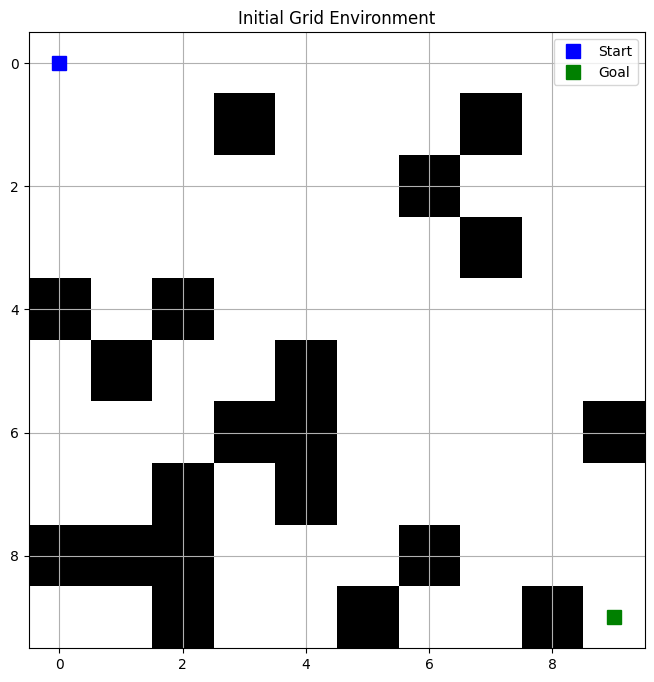

Training Q-Learning Agent...
Episode 0/1000, Reward: -371, Epsilon: 0.367
Episode 100/1000, Reward: 67, Epsilon: 0.010
Episode 200/1000, Reward: 83, Epsilon: 0.010
Episode 300/1000, Reward: 83, Epsilon: 0.010
Episode 400/1000, Reward: 83, Epsilon: 0.010
Episode 500/1000, Reward: 83, Epsilon: 0.010
Episode 600/1000, Reward: 83, Epsilon: 0.010
Episode 700/1000, Reward: 83, Epsilon: 0.010
Episode 800/1000, Reward: 83, Epsilon: 0.010
Episode 900/1000, Reward: 83, Epsilon: 0.010
Q-Learning training completed in 0.32 seconds

Training DQN Agent...
Episode 0/250, Reward: -272, Epsilon: 0.396
Episode 10/250, Reward: -200, Epsilon: 0.010
Episode 20/250, Reward: -200, Epsilon: 0.010
Episode 30/250, Reward: -209, Epsilon: 0.010
Episode 40/250, Reward: -200, Epsilon: 0.010
Episode 50/250, Reward: -200, Epsilon: 0.010
Episode 60/250, Reward: -200, Epsilon: 0.010
Episode 70/250, Reward: -200, Epsilon: 0.010
Episode 80/250, Reward: -200, Epsilon: 0.010
Episode 90/250, Reward: -200, Epsilon: 0.010
Epi

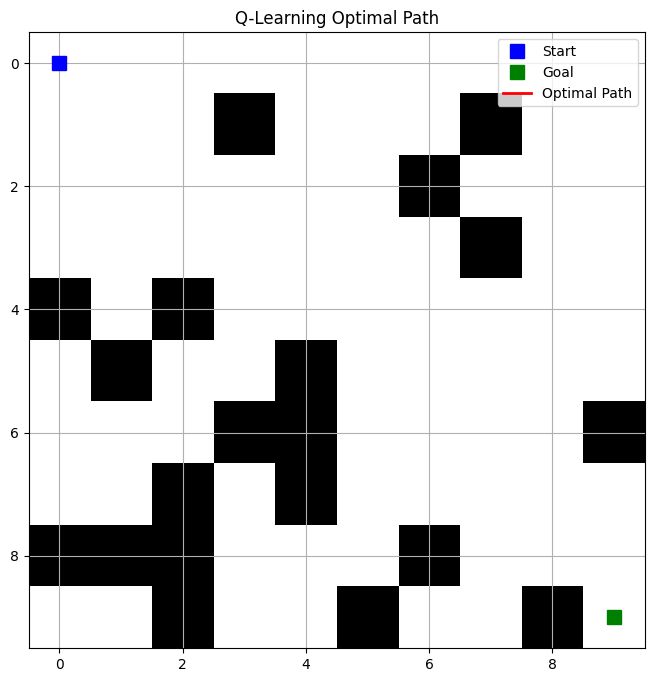

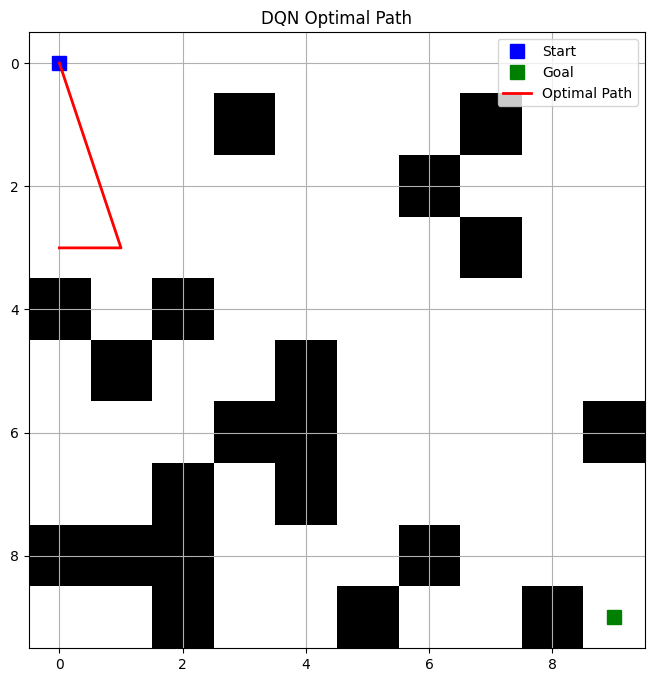

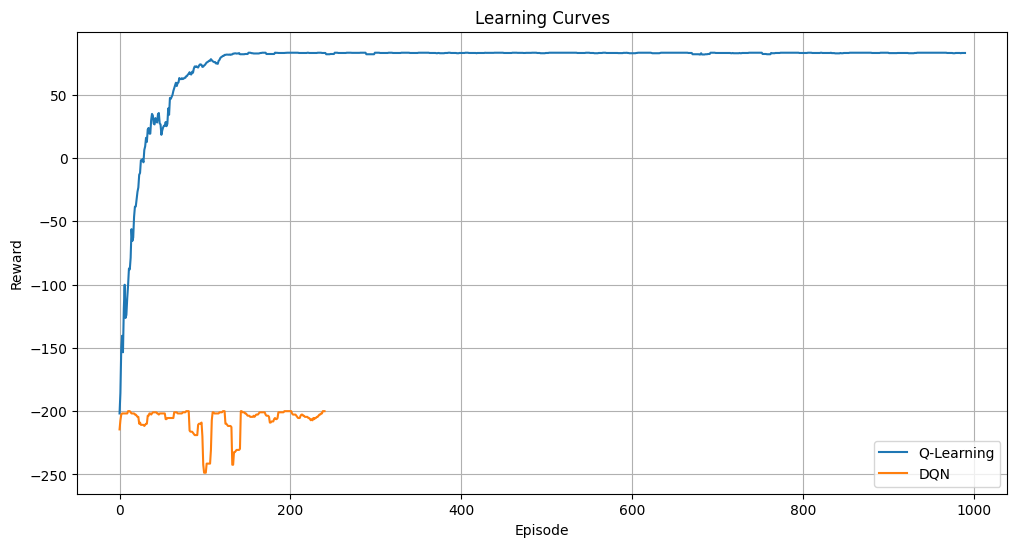

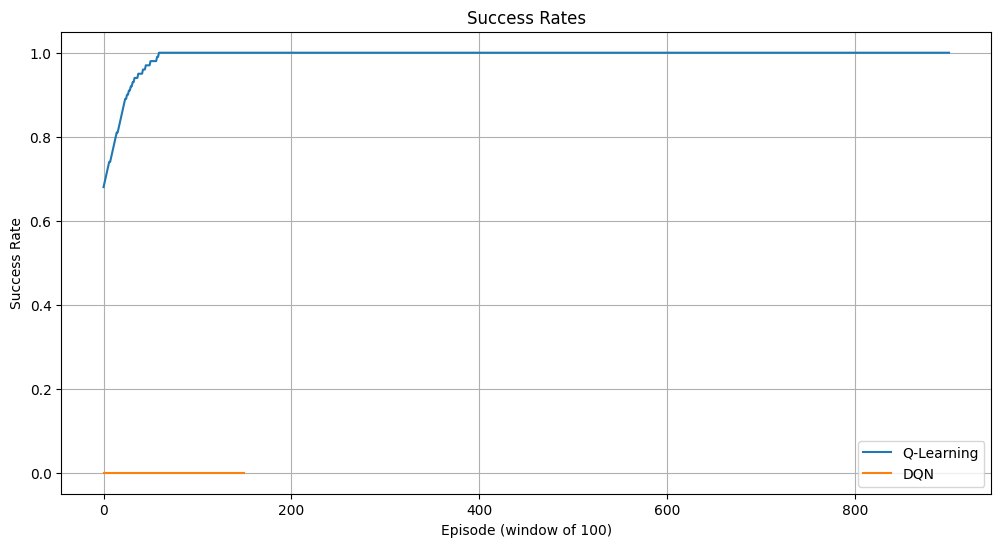


Performance Comparison:
Q-Learning:
 - Training time: 0.32 seconds
 - Final average reward (last 100 episodes): 82.85
 - Success rate (last 100 episodes): 1.00

DQN:
 - Training time: 23329.28 seconds
 - Final average reward (last 100 episodes): -203.15
 - Success rate (last 100 episodes): 0.00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

class GridWorld:
    def __init__(self, size=10, obstacle_percentage=0.2):
        self.size = size
        self.grid = np.zeros((size, size))  # 0: free space, 1: obstacle
        self.start_pos = (0, 0)
        self.goal_pos = (size-1, size-1)
        self.current_pos = self.start_pos
        self.actions = [0, 1, 2, 3]  # UP, RIGHT, DOWN, LEFT
        self.max_steps = 200
        self.steps_taken = 0

        # Generate obstacles
        self._generate_environment(obstacle_percentage)

    def _generate_environment(self, obstacle_percentage):
        # Start position
        self.grid[self.start_pos] = 0

        # Goal position
        self.grid[self.goal_pos] = 0

        # Place obstacles randomly
        num_obstacles = int(obstacle_percentage * self.size * self.size)
        obstacle_cells = 0

        while obstacle_cells < num_obstacles:
            i, j = np.random.randint(0, self.size), np.random.randint(0, self.size)
            if (i, j) != self.start_pos and (i, j) != self.goal_pos and self.grid[i, j] != 1:
                self.grid[i, j] = 1
                obstacle_cells += 1

    def reset(self):
        self.current_pos = self.start_pos
        self.steps_taken = 0
        return self._get_state()

    def _get_state(self):
        # For Q-learning, we return the state as a tuple of coordinates
        return self.current_pos

    def _get_state_dqn(self):
        # For DQN, we return a flattened one-hot encoded state
        state = np.zeros((self.size, self.size))
        state[self.current_pos] = 1
        return state.flatten()

    def step(self, action):
        self.steps_taken += 1

        # Get next position
        next_pos = self._get_next_position(action)

        # Check if next position is valid
        if next_pos[0] < 0 or next_pos[0] >= self.size or next_pos[1] < 0 or next_pos[1] >= self.size:
            # Out of bounds
            reward = -10
            done = False
        elif self.grid[next_pos] == 1:
            # Hit an obstacle
            reward = -10
            done = False
        elif next_pos == self.goal_pos:
            # Reached goal
            self.current_pos = next_pos
            reward = 100
            done = True
        else:
            # Valid move to free space
            self.current_pos = next_pos
            reward = -1
            done = False

        # Check if maximum steps exceeded
        if self.steps_taken >= self.max_steps and not done:
            done = True

        return self._get_state(), reward, done

    def step_dqn(self, action):
        state, reward, done = self.step(action)
        return self._get_state_dqn(), reward, done

    def _get_next_position(self, action):
        i, j = self.current_pos

        if action == 0:  # UP
            return (max(0, i-1), j)
        elif action == 1:  # RIGHT
            return (i, min(self.size-1, j+1))
        elif action == 2:  # DOWN
            return (min(self.size-1, i+1), j)
        elif action == 3:  # LEFT
            return (i, max(0, j-1))

    def render(self, policy=None, title="Grid World"):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.grid, cmap='binary')

        # Mark start and goal
        plt.plot(self.start_pos[1], self.start_pos[0], 'bs', markersize=10, label='Start')
        plt.plot(self.goal_pos[1], self.goal_pos[0], 'gs', markersize=10, label='Goal')

        # Plot optimal path if policy is provided\
        if policy is not None:
            path = self._get_optimal_path(policy)
            path_i, path_j = zip(*path)
            plt.plot(path_j, path_i, 'r-', linewidth=2, label='Optimal Path')

        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.show()

    def _get_optimal_path(self, policy):
        path = [self.start_pos]
        current = self.start_pos

        for _ in range(self.size * self.size):  # Maximum possible path length
            if current == self.goal_pos:
                break

            best_action = policy[current]
            next_pos = self._get_next_position(best_action)

            # If we hit an obstacle or stay in place, we've got a problem with the policy
            if self.grid[next_pos] == 1 or next_pos == current:
                break

            path.append(next_pos)
            current = next_pos

        return path


class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Initialize Q-table with zeros
        self.q_table = {}
        for i in range(env.size):
            for j in range(env.size):
                self.q_table[(i, j)] = np.zeros(len(env.actions))

    def get_action(self, state):
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.actions)
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        # Q-learning update rule
        best_next_action = np.argmax(self.q_table[next_state])

        if done:
            target = reward
        else:
            target = reward + self.gamma * self.q_table[next_state][best_next_action]

        self.q_table[state][action] += self.alpha * (target - self.q_table[state][action])

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self):
        policy = {}
        for state in self.q_table:
            policy[state] = np.argmax(self.q_table[state])
        return policy


class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.002, gamma=0.99,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 memory_size=2000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        # Create main model (for training)
        self.model = self._build_model()

        # Create target model (for stability)
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        # Neural network for DQN
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy weights from main model to target model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        # Store experience in replay memory
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = np.reshape(state, [1, self.state_size])
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def replay(self):
        # Experience replay
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch of experiences from memory
        minibatch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))

        # Extract states and next_states for batch prediction
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            next_states[i] = next_state

        # Batch predict current Q-values and next Q-values
        current_q_values = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        # Update Q-values for the actions taken
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(next_q_values[i])

            current_q_values[i][action] = target

        # Train the model with updated Q-values
        self.model.fit(states, current_q_values, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self, env):
        policy = {}
        for i in range(env.size):
            for j in range(env.size):
                state = np.zeros((env.size, env.size))
                state[i, j] = 1
                state = state.flatten()
                state = np.reshape(state, [1, self.state_size])
                q_values = self.model.predict(state, verbose=0)
                policy[(i, j)] = np.argmax(q_values[0])
        return policy


def train_q_learning(env, episodes=1000):
    agent = QLearningAgent(env)
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        rewards.append(episode_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.3f}")

    return agent, rewards


def train_dqn(env, episodes=250):
    state_size = env.size * env.size  # Flattened one-hot encoded grid
    action_size = len(env.actions)
    agent = DQNAgent(state_size, action_size, memory_size=1000, batch_size=16)
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        state = env._get_state_dqn()  # Get flattened state for DQN
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step_dqn(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            # Training step
            agent.replay()

        rewards.append(episode_reward)

        # Update target network every 10 episodes
        if episode % 10 == 0:
            agent.update_target_model()
            print(f"Episode {episode}/{episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.3f}")

    return agent, rewards


def plot_learning_curves(q_rewards, dqn_rewards):
    plt.figure(figsize=(12, 6))

    # Smooth the curves for better visibility
    q_rewards_smooth = np.convolve(q_rewards, np.ones(10)/10, mode='valid')
    dqn_rewards_smooth = np.convolve(dqn_rewards, np.ones(10)/10, mode='valid')

    plt.plot(q_rewards_smooth, label='Q-Learning')
    plt.plot(dqn_rewards_smooth, label='DQN')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_success_rates(q_rewards, dqn_rewards, window_size=100):
    # Calculate success rates (episodes where reward > 0)
    q_success = [1 if r > 0 else 0 for r in q_rewards]
    dqn_success = [1 if r > 0 else 0 for r in dqn_rewards]

    # Use a sliding window to calculate success rates
    q_success_rates = []
    dqn_success_rates = []

    for i in range(window_size, len(q_success)+1):
        q_success_rates.append(sum(q_success[i-window_size:i]) / window_size)

    for i in range(window_size, len(dqn_success)+1):
        dqn_success_rates.append(sum(dqn_success[i-window_size:i]) / window_size)

    plt.figure(figsize=(12, 6))
    plt.plot(q_success_rates, label='Q-Learning')
    plt.plot(dqn_success_rates, label='DQN')
    plt.xlabel('Episode (window of 100)')
    plt.ylabel('Success Rate')
    plt.title('Success Rates')
    plt.legend()
    plt.grid(True)
    plt.show()


# Main execution
if __name__ == "__main__":
    # Create environment
    env = GridWorld(size=10, obstacle_percentage=0.2)

    # Display initial environment
    env.render(title="Initial Grid Environment")

    # Train Q-learning agent
    print("Training Q-Learning Agent...")
    start_time = time.time()
    q_agent, q_rewards = train_q_learning(env, episodes=1000)
    q_time = time.time() - start_time
    print(f"Q-Learning training completed in {q_time:.2f} seconds")

    # Train DQN agent
    print("\nTraining DQN Agent...")
    start_time = time.time()
    dqn_agent, dqn_rewards = train_dqn(env, episodes=250)
    dqn_time = time.time() - start_time
    print(f"DQN training completed in {dqn_time:.2f} seconds")

    # Get policies
    q_policy = q_agent.get_policy()
    dqn_policy = dqn_agent.get_policy(env)

    # Visualize optimal paths
    env.render(policy=q_policy, title="Q-Learning Optimal Path")
    env.render(policy=dqn_policy, title="DQN Optimal Path")

    # Plot learning curves
    plot_learning_curves(q_rewards, dqn_rewards)

    # Plot success rates
    plot_success_rates(q_rewards, dqn_rewards)

    # Print performance comparison
    print("\nPerformance Comparison:")
    print(f"Q-Learning:")
    print(f" - Training time: {q_time:.2f} seconds")
    print(f" - Final average reward (last 100 episodes): {np.mean(q_rewards[-100:]):.2f}")
    print(f" - Success rate (last 100 episodes): {sum([1 if r > 0 else 0 for r in q_rewards[-100:]]) / 100:.2f}")

    print(f"\nDQN:")
    print(f" - Training time: {dqn_time:.2f} seconds")
    print(f" - Final average reward (last 100 episodes): {np.mean(dqn_rewards[-100:]):.2f}")
    print(f" - Success rate (last 100 episodes): {sum([1 if r > 0 else 0 for r in dqn_rewards[-100:]]) / 100:.2f}")